# This is a tutorial to show how to find potential RBP complexes with CLIP peaks.
- Assumption: RBPs forming complex will bind overlapping places in the genome
- How to quantify "overlap"? Jaccard Index/similarity
    - [Link](https://www.learndatasci.com/glossary/jaccard-similarity/)
- Plan:
    - For each pair of RBP, we are going to calculate their jaccard index to measure how similar their binding site is
    - Then use a clustermap to show clusters of RBP binding similar places.
- Implementation detail:
    - We have CLIPped >400 eCLIP, which means we will be computing > 79800 combinations [n choose k calculator](https://www.hackmath.net/en/calculator/n-choose-k?n=400&k=2&order=0&repeat=0)
    - To save time this tutorial we will pick a small subset to practice.
    - I will show two method to harness of power of parallel computation, instead of doing lots of for loops
        - snakemake: use multiple nodes to send out jobs.
        - scipy and numpy package is naturally multi-thread.
    - Here are two senarios:
        1. All CLIPs were processed with the same skipper annotations, such that window ID "1" always refer to the same genomic interval. This way we can compile a huge binary matrix where is (n_windows)*(n_rbps) and use `scipy` to calculate jaccard distance.
        2. Some CLIPs were processe with different skipper annotation: we will need `bedtools` to evaluate the overlap.

## Scenario 1: All CLIPs were process with the same annotation

In [1]:
# this is a package to help you write paths elegantly in python
from pathlib import Path
skipper_dir = Path('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows')
rbps_to_include = list(skipper_dir.glob('SF3B*')
                )+list(skipper_dir.glob('FXR*')
                )+list(skipper_dir.glob('FMR*')
                )+list(skipper_dir.glob('IGF*'))


In [2]:
rbps_to_include

[PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/SF3B4_K562.reproducible_enriched_windows.tsv.gz'),
 PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/SF3B1_K562.reproducible_enriched_windows.tsv.gz'),
 PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/FXR2_K562.reproducible_enriched_windows.tsv.gz'),
 PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/FXR1_K562.reproducible_enriched_windows.tsv.gz'),
 PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/FMR1_K562.reproducible_enriched_windows.tsv.gz'),
 PosixPath('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enr

In [3]:
# let's look at 1 output
import pandas as pd
df = pd.read_csv(rbps_to_include[0], sep = '\t')

In [4]:
df.head() # name is the "window ID"

,chr,start,end,name,score,strand,gc,gc_bin,chrom,feature_id,...,input_sum,clip_sum,enrichment_n,enrichment_l2or_min,enrichment_l2or_mean,enrichment_l2or_max,p_max,p_min,q_max,q_min
0,chrX,72376978,72377073,5847366,0,-,0.494737,"(0.49,0.53]",chrX,634540,...,14,11888,2,10.52140,10.816550,11.11170,1.000000e-12,1.000000e-12,1.243100e-09,6.724260e-10
1,chr1,52754321,52754391,80054,0,+,0.300000,"(0.29,0.323]",chr1,11338,...,0,392,2,9.38025,9.844075,10.30790,1.000000e-12,1.000000e-12,1.243100e-09,6.724260e-10
2,chr6,116712332,116712431,2159645,0,+,0.363636,"(0.354,0.384]",chr6,219588,...,0,311,2,9.15933,9.491675,9.82402,1.000000e-12,1.000000e-12,1.243100e-09,6.724260e-10
3,chr1,180796715,180796814,211517,0,+,0.323232,"(0.29,0.323]",chr1,25658,...,0,295,2,9.09123,9.466050,9.84087,1.000000e-12,1.000000e-12,1.243100e-09,6.724260e-10
4,chr13,20612196,20612296,4045519,0,+,0.410000,"(0.384,0.416]",chr13,414968,...,6,1464,2,9.10101,9.343000,9.58499,1.000000e-12,1.000000e-12,1.243100e-09,6.724260e-10


In [5]:
df['q_max'].max() # all windows in the file is significant

0.199919

In [6]:
# construct the (n_windows)*(n_rbps) binary matrix
# this is called "list comprehension" which is a lazy way to write for loops.
binary_matrix = ~pd.concat(
                [pd.read_csv(f, sep = '\t').set_index('name')['q_max'] for f in rbps_to_include], # list comprehension
                axis = 1).isnull() # not null means not nan
binary_matrix.columns = [f.name.split('.')[0] for f in rbps_to_include]

In [7]:
binary_matrix.head() # this is what we want

,SF3B4_K562,SF3B1_K562,FXR2_K562,FXR1_K562,FMR1_K562,IGF2BP2_K562,IGF2BP1_K562
name,,,,,,,
5847366,True,True,False,False,False,False,False
80054,True,False,False,False,True,False,False
2159645,True,False,False,False,False,False,False
211517,True,False,False,False,False,False,False
4045519,True,False,False,False,False,False,False


In [8]:
# or the for loop does the same
all_binary_vectors = []
for f in rbps_to_include:
    df = pd.read_csv(f, sep = '\t')
    rbp_name = f.name.split('.')[0]
    df[rbp_name]=True # record these window are bound by RBP
    is_bound = df.set_index('name')[rbp_name]
    all_binary_vectors.append(is_bound)
binary_matrix_from_for_loop = pd.concat(all_binary_vectors, axis = 1).fillna(False)

In [9]:
binary_matrix_from_for_loop.eq(binary_matrix).all().all() # it is all the same

True

In [10]:
# let's do the thing
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
# the function
def compute_jaccard_index(identity_tbl):
    ''' identity tbl: pd.DataFrame where each row is a window, each column is a RBP 
    values should be True/False where True means it is a binding site for a RBP
    '''

    d_condense = pdist(identity_tbl.T, 'jaccard') # lazy way to compute pairwise distance in a matrix
    d = pd.DataFrame(1-squareform(d_condense), # jaccard similarity = 1-jaccard "distance"
                     index = identity_tbl.columns, columns = identity_tbl.columns)
    return d


In [11]:
jaccard = compute_jaccard_index(binary_matrix)

In [12]:
jaccard.head()

,SF3B4_K562,SF3B1_K562,FXR2_K562,FXR1_K562,FMR1_K562,IGF2BP2_K562,IGF2BP1_K562
SF3B4_K562,1.000000,0.000522,0.010032,0.008631,0.011671,0.010219,0.010937
SF3B1_K562,0.000522,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FXR2_K562,0.010032,0.000000,1.000000,0.283689,0.372985,0.043178,0.031672
FXR1_K562,0.008631,0.000000,0.283689,1.000000,0.207544,0.037482,0.035384
FMR1_K562,0.011671,0.000000,0.372985,0.207544,1.000000,0.051355,0.038935


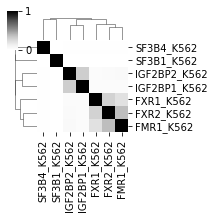

In [13]:
# plot it
sns.clustermap(jaccard, cmap = 'Greys', figsize = (3,3))

### practice 
- Can you quantify jaccard index in 3'UTR regions only/5'UTR regions...etc. Modify the code to do so

## Scenario 2: Not all CLIPs were processed with the same annotation
- we will include some HepG2 clips as an example. These CLIPs were processed using different windows therefore window ID 5678 might mean different genomic interval in HepG2 and K562.
- we will use snakemake to parallel submit jobs. It the same as what you did with `qsub something.sh` but more elegant.
- What is snakemake
    - a pipeline language
    - what is a pipeline? doing 1 step after another all the end until you get all you want. 
        - trim adapter -> trim UMI -> map read -> count reads -> call peaks
        - call peaks -> call motif
        - call peaks -> quantify bindin in each region
        - trim adapter -> map reads -> featureCount -> DeSeq -> plot volcano
        - trim adapter -> map reads -> rMATs -> RBPmaps
        - skipper reproducible windows -> format into bed -> calculate jaccard using bedtool
    - Why End-to-end pipelines:
        - avoid manually sending jobs for each step makes your workflow reproducible.
        - avoid manually naming stuffs in output/input to avoid typo and then renaming/moving stuffs
        - Automate as much as possible such that you don't have to "spend time" computing. Computers do the thing.
        - Write it once, use it many times
        - Easy transfer to collaborators and colleagues. (one more step needed, containerize)
    - [snakemake tutorial](https://snakemake.readthedocs.io/en/stable/).
    - snakemake offers a way to format shell commands and inject "sample names" into the input/output
        - these are called "wildcards", things in squarely brackets "{sample_name}.peaks.bed".
    - you can also run inline python in snakemake files
- Go to `jaccard.smk` to see implementation
    - always run snakemake in an interactive session: `qsub -I -q home-yeo -l nodes=1:ppn=1 -l walltime=2:00:00`
    - `module load snakemake`
    - `snakemake -s jaccard.smk -n`. `-n` for dry run
    - `snakemake -s jaccard.smk -j 5`: run 5 jobs at most at a time "multithreading"
    - `snakemake -s jaccard.smk -j 5 output/FXR1_K562.FXR2_K562.jaccard.txt`: we will try one output "FXR1_K562.FXR2_K562.jaccard.txt"
- Now we decorate the rules to make it `qsub` each job to different nodes:
    - see `jaccard-decorate.smk`
    - "params", recording the qsub parameters, where to put error files, stdout and number of cores, how many minutes to run
    - now:
        ```
        snakemake -s jaccard-decorate.smk \
                -j 3 \
                --cluster "qsub -l walltime={params.run_time} -l nodes=1:ppn={params.cores} -q home-yeo -e {params.error_out_file} -o {params.out_file}"
        ```
- How to debug in snakemake

In [14]:
# these are from the snakemake
jaccard_files = list(Path('output/').glob('*.jaccard.txt'))
jaccard_values = [pd.read_csv(f, sep = '\t')['jaccard'].values[0] for f in jaccard_files]
sample_ones = [f.name.split('.')[0] for f in jaccard_files]
sample_twos = [f.name.split('.')[1] for f in jaccard_files]

jaccard_data = pd.DataFrame([sample_ones, sample_twos, jaccard_values], index = ['rbp1', 'rbp2', 'jaccard']).T

In [15]:
jaccard_data.head()

,rbp1,rbp2,jaccard
0,FXR1_K562,IGF2BP1_K562,0.026089
1,FXR1_K562,FXR2_K562,0.241598
2,FXR1_K562,FMR1_K562,0.174349
3,IGF2BP2_K562,FXR2_HepG2,0.034581
4,SF3B1_K562,IGF2BP2_K562,0


In [16]:
# make symmetric
jaccard_data2 = jaccard_data.copy()
jaccard_data2.rename({'rbp1': 'rbp2', 'rbp2':'rbp1'}, axis = 1, inplace = True)

In [17]:
jaccard_data = pd.concat([jaccard_data, jaccard_data2], axis = 0)

In [18]:
jaccard_pv = pd.pivot_table(jaccard_data, index = 'rbp1', columns = 'rbp2', values = 'jaccard')

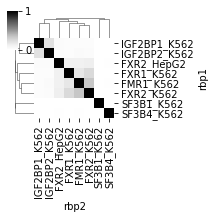

In [19]:
sns.clustermap(jaccard_pv.fillna(1), cmap = 'Greys', figsize = (3,3))

# Summary
- We found PPI from eCLIP binding sites
- Takeaway
    - How to use scipy to compute distance
    - How to send jobs in parallel with snakemake. NO MORE MANUAL QSUB.
- Nitty Gritty details:
    - [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp) is a lazy way to write foor loop
    - `dict()` and `zip`
    - pandas hacks and tricks `pd.concat` `pd.pivot_table`.
    - scipy hacks `pdist` `squareform`.
    - pathlib `Path()` helps you concatenate folders and filename
    
# Homework
- Agility in python and snakemake needs practice. Modify the snakemake file to:
    - compute jaccard index ONLY in certain genomic regions such as 5'SS
    - try your own CLIP data with a set of RBP of interest. It you don't have one download your favorite RBP from the ENCODE website
- Now you know how to read snakemake rules. Go ahead a try to:
    - try to read/dissect skipper snakemake rules `skipper.py` [here](https://github.com/YeoLab/skipper)
    - How does skipper make the pipeline reusable to different eCLIP dataset. hint: `Skipper_config.py`
    - How would you make `jaccard.smk` reusable to different sets of RBP and potentially eCLIPs in different folders?
        - hint: [configs](https://snakemake.readthedocs.io/en/stable/tutorial/advanced.html#step-2-config-files)
        - hint: [be modulized to mix and match](https://snakemake.readthedocs.io/en/stable/snakefiles/modularization.html) NEVER COPY AND PASTE! BAD!